In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
sub_process_names = [
    'Effluent treatment',
    'Li recovery',
    'Ni recovery',
    'Co recovery',
    'Mn recovery',
    'Solution purification',
    'Leaching',
    'Total'
]

In [4]:
def parse_contribution_tree(scenario):
    # Read the Excel file into a DataFrame
    df = pd.read_excel('contribution_tree.xlsx', 'Upstream tree')

    # Get the impact category and unit as the dataset name
    labels = df.columns[0].split(':')
    category = ','.join(labels[1:])[1:]
    unit = df.iloc[0][8]
    unit = unit[unit.find('[')+1:unit.find(']')]
    unit = ''.join(['[', unit, ']'])
    name = ''.join([category, ' ', unit])

    # Initialize variables
    processes = []
    final_rows = []
    current_subprocess_level = -1

    # Iterate through the rows of the dataframe
    for i, row in df.iterrows():
        # Replace nan by 0 in 'Direct contributions' column
        if pd.isna(row.iloc[-1]):
            row.iloc[-1] = 0

        # Determine the level by checking which cell is filled in the row
        level = next((j for j in range(len(row)) if not pd.isna(row[j])), len(row))
        if level == current_subprocess_level:
            current_subprocess_level -= 1

        # Check if the current row is a subprocess
        if row[level].startswith(scenario):
            current_subprocess_level = level
            row['Level'] = level
            final_rows.append(row.dropna().values)

        # Check if the row is an activity and needs to be retained
        elif not pd.isna(row[level]):
            # Check if the activity is directly under a subprocess
            if level - 1 == current_subprocess_level:
                # Direct child of a subprocess
                row['Level'] = level
                final_rows.append(row.dropna().values)

    # Create a new DataFrame from the filtered rows
    final_rows[0][-1] = 'Level'
    final_df = pd.DataFrame(final_rows)
    final_df.columns = final_df.iloc[0]
    final_df = final_df[1:]

    return name, final_df

In [5]:
def parse_sub_processes(df, sub_process_names):
    sub_process_totals = []
    sub_processes = []

    # Extract sub-process 'totals' (e.g. 'Leaching')
    for i, row in df.iterrows():
        # print(row['Level'])
        # print(sub_process_names[7 - row['Level']])
        df.loc[i, 'Sub-process'] = sub_process_names[row['Level'] - 1]
        if row[0].startswith('Baseline'):
            sub_process_totals.append(row)
            df.drop(index=i, inplace=True)
    sub_process_totals = pd.DataFrame(sub_process_totals, columns=df.columns)
    
    # Group sub-processes
    for i, g in df.groupby('Level'):
        sub_processes.append(g)
    
    return sub_process_totals, sub_processes

In [6]:
def parse_process_names(processes):
    for p in processes:
        for i, row in p.iterrows():
            split_row = row[0].split(' | ')
            p.loc[i, 'Processes'] = split_row[0]
            if row[0].startswith('market for'):
                p.loc[i, 'Processes'] = row[0][11:]
            if row[0].startswith('market group for'):
                p.loc[i, 'Processes'] = row[0][17:]
            if row[0].endswith('production'):
                p.loc[i, 'Processes'] = row[0][:-11]

    return processes

In [95]:
def pop_col(indices, cols, new_cols):
    for i in indices:
        col = cols[i]
        new_cols.append(col)
        cols[i] = ''

    return cols, new_cols

In [166]:
def arrange_by_value(df):
    cols = df.columns
    negative = []
    positive = []

    for col in cols:
        if df[col].any() < 0:
            negative.append(col)
        else:
            positive.append(col)
    
    new_cols = positive + negative

    return new_cols

In [7]:
category, contributions = parse_contribution_tree('Baseline')
sub_process_totals, sub_processes = parse_sub_processes(contributions, sub_process_names)

c:\ProgramData\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
sub_processes[0]

,Processes,Result [CTUh],Direct contribution [CTUh],Level,Sub-process
2,"market for hazardous waste, for underground de...",0.0,0,1,Effluent treatment
3,"market group for electricity, medium voltage |...",0.0,0,1,Effluent treatment
4,"market for wastewater, average | wastewater, a...",0.0,0.0,1,Effluent treatment
5,"market for quicklime, milled, packed | quickli...",0.0,0,1,Effluent treatment
6,market group for tap water | tap water | Cutof...,0.0,0,1,Effluent treatment
7,"market for wastewater, unpolluted | wastewater...",0.0,0,1,Effluent treatment


In [9]:
category

'Human toxicity, carcinogenic, inorganics [CTUh]'

In [10]:
parsed = parse_process_names(sub_processes)

In [12]:
parsed[0]

,Processes,Result [CTUh],Direct contribution [CTUh],Level,Sub-process
2,"hazardous waste, for underground deposit",0.0,0,1,Effluent treatment
3,"electricity, medium voltage",0.0,0,1,Effluent treatment
4,"wastewater, average",0.0,0.0,1,Effluent treatment
5,"quicklime, milled, packed",0.0,0,1,Effluent treatment
6,tap water,0.0,0,1,Effluent treatment
7,"wastewater, unpolluted",0.0,0,1,Effluent treatment


In [13]:
combined_df = pd.concat(sub_processes)
combined_df

,Processes,Result [CTUh],Direct contribution [CTUh],Level,Sub-process
2,"hazardous waste, for underground deposit",0.0,0,1,Effluent treatment
3,"electricity, medium voltage",0.0,0,1,Effluent treatment
4,"wastewater, average",0.0,0.0,1,Effluent treatment
5,"quicklime, milled, packed",0.0,0,1,Effluent treatment
6,tap water,0.0,0,1,Effluent treatment
7,"wastewater, unpolluted",0.0,0,1,Effluent treatment
9,"soda ash, dense",0.0,0,2,Li recovery
10,"electricity, medium voltage",0.0,0,2,Li recovery
11,tap water,0.0,0,2,Li recovery
12,"sodium sulfate, anhydrite",-0.0,0,2,Li recovery


In [190]:
pivot_df = combined_df.pivot(index='Sub-process', columns='Processes', values=combined_df.columns[1]).fillna(0)

#-------------------------------------------------------------------------------
# Write all the processes you want to omit from the figure in the list below
#-------------------------------------------------------------------------------

dropped = [
    'nickel sulfate'
]


#-------------------------------------------------------------------------------
# Comment or uncomment the following line to plot all or only those w\o
#  'dropped'
#-------------------------------------------------------------------------------

# pivot_df.drop(['nickel sulfate', 'cobalt sulfate'], axis=1, inplace=True)

In [191]:
#-------------------------------------------------------------------------------
# In this cell, the flows/processes will be rearranged so that positive values
#  will be first, and negative last.
#
# Alternatively, use the list 'indices' to define the order of columns (flows/
#  processes) in your legend manually.
#
# Run this cell to apply the changes and see the available indices, as well your
#  new list of flow/processes.
#
# Run the previous cell to reset the list variables.
#
# Run the next cell to plot the figure, and see the legend.
#-------------------------------------------------------------------------------

cols = pivot_df.columns.to_list()
used_cols = cols.copy()
new_cols = []

# new_cols = arrange_by_value(pivot_df)

# Modify this list. See the available indices below by running this cell.
# indices = []
indices = [18, 15, 7, 8, 14, 13, 1, 0, 9, 19, 17, 4, 5, 6, 20, 21, 16, 3, 11, 2, 12, 10]

used_cols, new_cols = pop_col(indices, used_cols, new_cols)
print('remaining:')
for i, col in enumerate(used_cols):
    print(i, col)

print('\ncurrent:')
for i, col in enumerate(new_cols):
    print(col)

remaining:
0 
1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 

current:
sulfuric acid
sodium hydroxide, without water, in 50% solution state
hydrogen peroxide, without water, in 50% solution state
hydrogen sulfide
soda ash, dense
quicklime, milled, packed
D2EHPA
Cyanex 272
kerosene
tap water
steam, in chemical industry
electricity, medium voltage
hazardous waste, for incineration
hazardous waste, for underground deposit
wastewater, average
wastewater, unpolluted
sodium sulfate, anhydrite
copper concentrate, sulfide ore
manganese sulfate
cobalt sulfate
nickel sulfate
lithium carbonate


In [192]:
pivot_df = pivot_df[new_cols]
pivot_df

Processes,sulfuric acid,"sodium hydroxide, without water, in 50% solution state","hydrogen peroxide, without water, in 50% solution state",hydrogen sulfide,"soda ash, dense","quicklime, milled, packed",D2EHPA,Cyanex 272,kerosene,tap water,...,"hazardous waste, for incineration","hazardous waste, for underground deposit","wastewater, average","wastewater, unpolluted","sodium sulfate, anhydrite","copper concentrate, sulfide ore",manganese sulfate,cobalt sulfate,nickel sulfate,lithium carbonate
Sub-process,,,,,,,,,,,,,,,,,,,,,
Co recovery,6.390661e-09,2.002328e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.401727e-08,2.658210e-09,1.799891e-10,...,5.819872e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-0.000003,0.000000,0.000000e+00
Effluent treatment,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.353848e-10,0.000000e+00,0.000000e+00,0.000000e+00,3.306377e-10,...,0.000000e+00,2.368781e-08,1.199468e-09,2.983697e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
Leaching,4.083175e-08,0.000000e+00,5.640082e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.770914e-10,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00
Li recovery,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.017052e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.022080e-10,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.826448e-07,0.000000e+00,0.000000e+00,0.000000,0.000000,-3.047034e-07
Mn recovery,6.038279e-09,3.192043e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.886538e-08,0.000000e+00,3.627396e-09,1.340658e-10,...,5.404318e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.096152e-08,0.000000,0.000000,0.000000e+00
Ni recovery,1.963875e-08,2.212516e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.722041e-08,0.000000e+00,4.182558e-09,3.731358e-10,...,8.633381e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-0.000007,0.000000e+00
Solution purification,0.000000e+00,2.708141e-08,1.029164e-12,1.990384e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.136109e-10,...,0.000000e+00,2.307165e-08,0.000000e+00,0.000000e+00,0.000000e+00,-5.382026e-08,0.000000e+00,0.000000,0.000000,0.000000e+00


In [218]:
# A couple of manual tidy-ups to the column names
pivot_df.rename({'sodium hydroxide, without water, in 50% solution state': 'sodium hydroxide'}, axis=1, inplace=True)
pivot_df.rename({'hydrogen peroxide, without water, in 50% solution state': 'hydrogen peroxide'}, axis=1, inplace=True)

In [226]:
# Define the colormap
positive_colors = mpl.colormaps['Oranges_r'].resampled(148)
negative_colors = mpl.colormaps['Blues'].resampled(108)

new_colors = np.vstack((
    positive_colors(np.linspace(0, 1, 158)),
    negative_colors(np.linspace(0, 1, 98))
))

# my_cmap = mpl.colors.ListedColormap(new_colors)
my_cmap = mpl.colormaps['tab20b']

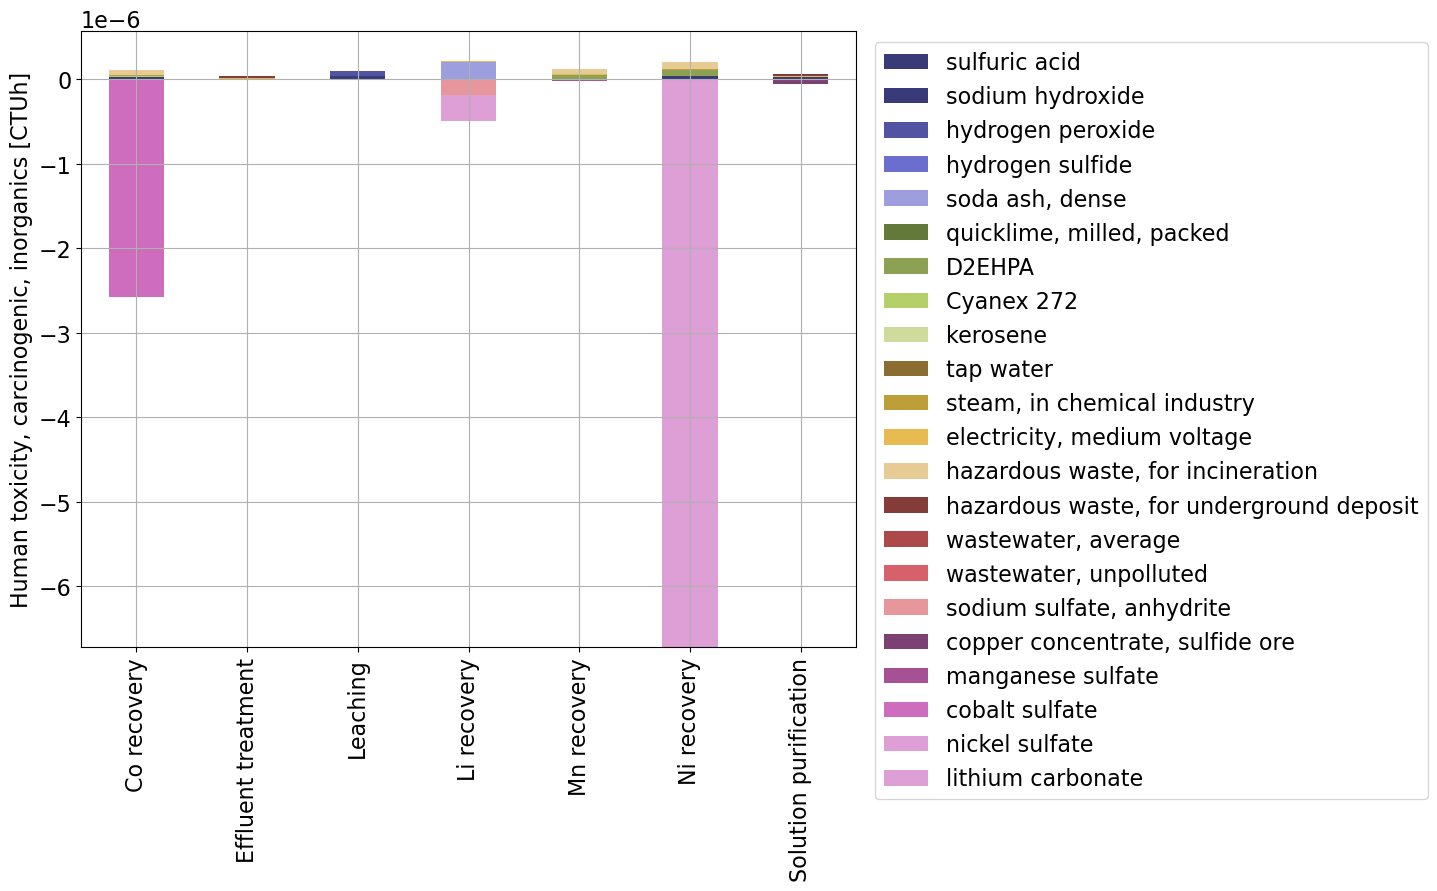

In [245]:
fig, ax = plt.subplots(figsize=(10, 8))

pivot_df.plot.bar(stacked=True, grid=True, ax=ax, cmap=my_cmap)
plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.xlabel('')
plt.ylabel(category)
mpl.rcParams.update({'font.size': 16})

plt.show()